# Scikit-image notebook to be compared with OpenCV

In this notebook, I have replicated the work of Sarah from`sarah_opencv.ipynb`. <br>
It should serve as a comparison of the two tools.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np


In [2]:
def sideBside(img1, img2, ttl1='Original image', ttl2='Result'):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    ax = axes.ravel()

    ax[0].imshow(img1, cmap=plt.cm.gray)
    ax[0].set_title(ttl1)

    ax[1].imshow(img2, cmap=plt.cm.gray)
    ax[1].set_title(ttl2)

    for a in ax:
        a.axis('off')

    plt.show()

In [3]:

from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.exposure import histogram
from skimage import filters as flt


In [6]:
fname = '../data/interim/merged_data/not_measured/9L-59_10x.jpg' #NICE
img = io.imread(fname)
img_small = resize(img, (500, 500), anti_aliasing=True)


In case of using resize function, it is better to reduce the dimensions in integer factors.,br.
For example:
```python
resize(img, (img.shape[0] // 4, img.shape[1] // 4), anti_aliasing=True)
```

In the example above I use 500x500 following Sarah's arbitrary choice.

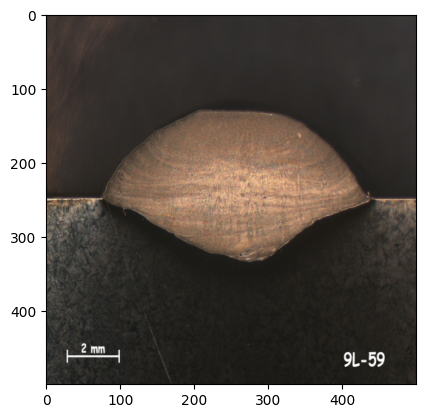

In [7]:
plt.imshow(img_small)
plt.show()

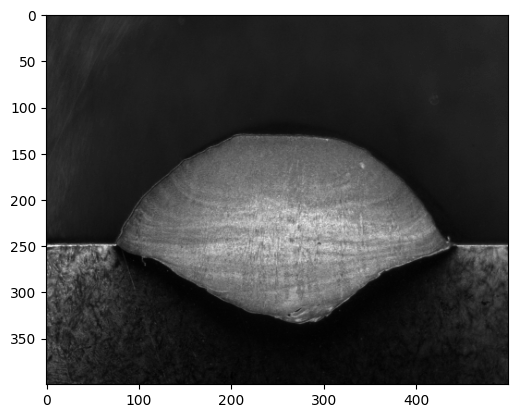

In [8]:

#Cropping manually the scale and ID region
img_small = img_small[0:400,0:500]

gray = rgb2gray(img_small)
plt.imshow(gray, cmap='gray')
plt.show()

Let's look at the histogram

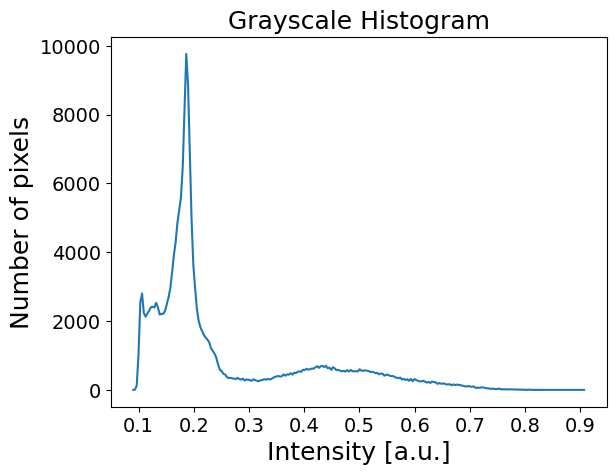

In [13]:
hist, hist_centers = histogram(gray, nbins=256)
plt.plot(hist_centers, hist)
plt.title('Grayscale Histogram', fontsize=18)
plt.xlabel('Intensity [a.u.]', fontsize=18)
plt.ylabel('Number of pixels', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

The Shape of the histogram is different than Sarah's (OpenCV).
It seems as though the information values of the grayscale are normalized to 1. in what follows I will try to identify the origin of this normalization. 

In [7]:
print('the maximum of original is : {}'.format(img.max()))
print('the maximum after resize with aliasing is : {}'.format(img_small.max()))
print('the maximum after resize without aliasing is : {}'.format(resize(img, (500, 500),\
                                                                      anti_aliasing=False).max()))
print('the maximum of gray is : {}'.format(gray.max()))

the maximum of original is : 255
the maximum after resize with aliasing is : 0.9890740217786511
the maximum after resize without aliasing is : 1.0
the maximum of gray is : 0.9082481139934147


It seems that the resize function of skimage normalizes the value range.
The origin of this issue comes from the fact that skimage converts the values of the image from `numpy.uint8` to `numpy.float64`. I will continue with the skimage type and adapt Sarah's parameters to this new standad. If there will be a need for working with `numpy.unit8`, one can use the following conversion:

```python
# Convert the image to a 0-255 scale.
img_small = 255 * img_small
# Convert to integer data type pixels.
img_small = img_small.astype(np.uint8)
```

## Applying Theshold

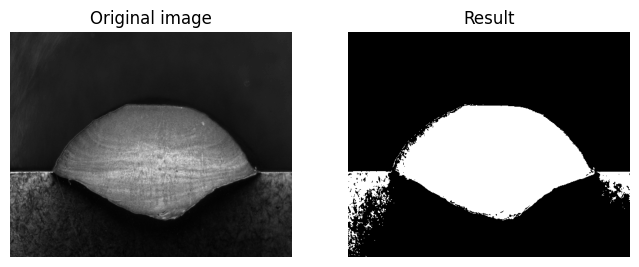

In [13]:
binary = gray > (75/255)

sideBside(gray, binary)


Apply a Gaussian blur to the image to reduce noise. <br>
**Note:** Sarah added some parameters that are different. 

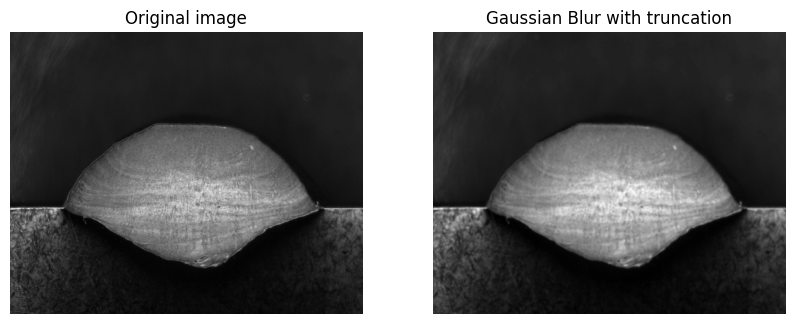

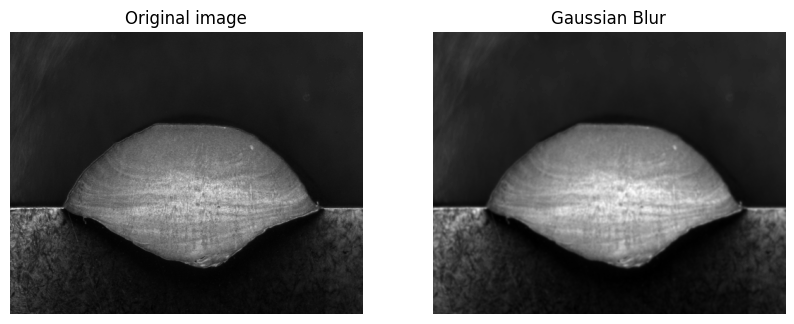

In [84]:
blurred_image = flt.gaussian(gray, sigma=1, truncate=1/2)

sideBside(gray, blurred_image, ttl2='Gaussian Blur with truncation')

blurred_image = flt.gaussian(gray)

sideBside(gray, blurred_image, ttl2='Gaussian Blur')

Apply Canny edge detector to the blurred image. the imputs 25, 75 are guided by the histogram of insensities

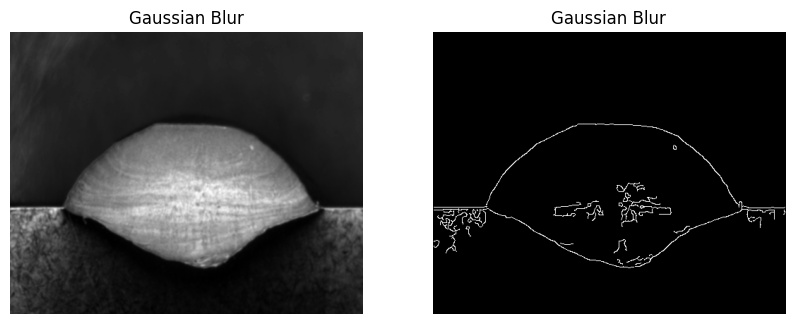

In [51]:
from skimage.feature import canny
edges_image = canny(blurred_image, low_threshold=25/255, high_threshold=75/255)
sideBside(blurred_image, edges_image, ttl1='Gaussian Blur', ttl2='Gaussian Blur')

## Find contours

45 contour(s) found!


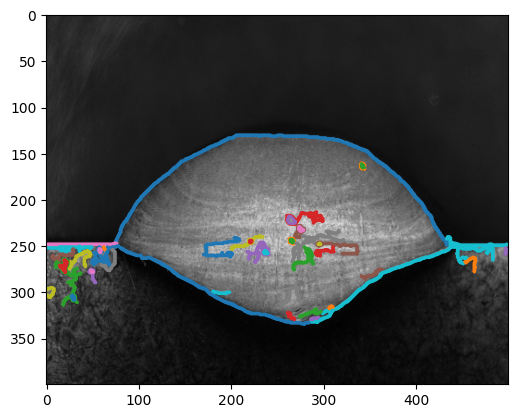

In [28]:
from skimage.measure import find_contours


contours = find_contours(edges_image, fully_connected='high')
print(f'{len(contours)} contour(s) found!')


fig, ax = plt.subplots()
ax.imshow(gray, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)


Plotting the longest edge.

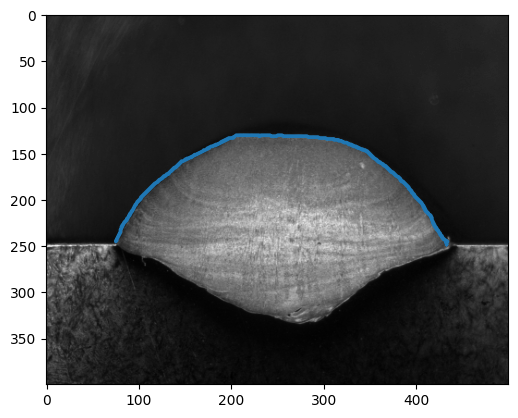

In [37]:
fig, ax = plt.subplots()
ax.imshow(gray, cmap=plt.cm.gray)

ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
plt.show()

Plotting the 3 longest edges.

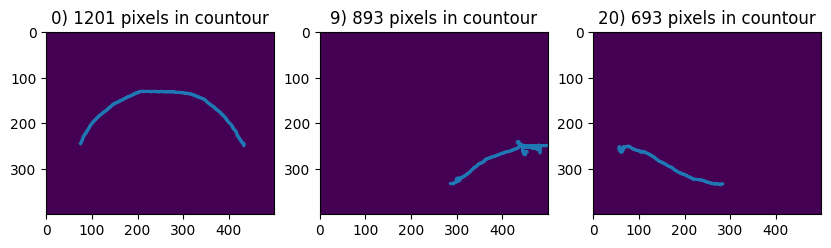

In [61]:

# --- Create a blank image
mask = np.zeros(gray.shape)

pixels_in_contour = []

fig, axes = plt.subplots(ncols=3, figsize=(10, 4))
ax = axes.ravel()
i=0

minLength = 500

#--- Find contours
for j, contour in enumerate(contours): 
   if contour.shape[0] > minLength:
      ax[i].imshow(mask)
      ax[i].plot(contour[:, 1], contour[:, 0], linewidth=2)
      ax[i].set_title('{}) {} pixels in countour'.format(j, contour.shape[0]))
      i = i+1


Concatenating the three longest contours

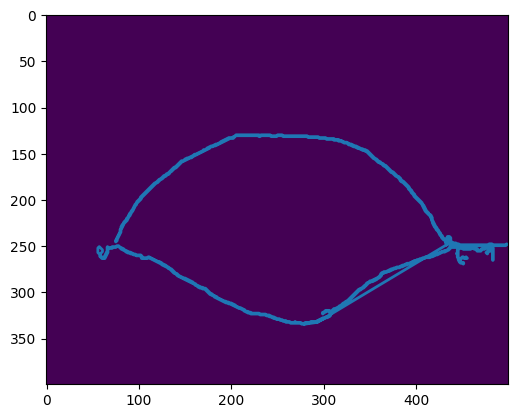

In [65]:
closedContour = np.concatenate([contours[0], contours[9], contours[20]])
plt.imshow(mask)
plt.plot(closedContour[:, 1], closedContour[:, 0], linewidth=2)
plt.show()

## Hough lines

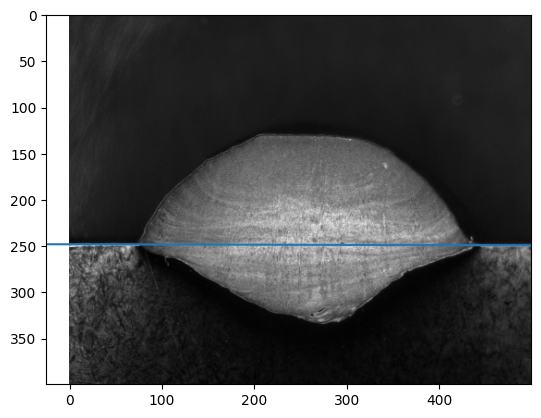

In [85]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import line as draw_line

plt.imshow(gray, cmap=plt.cm.gray)

# Set a precision.
angleRange = [np.pi * 3/8, np.pi * 5/8]
tested_angles = np.linspace(angleRange[0], angleRange[1], 360, endpoint=False)
h, theta, d = hough_line(edges_image, theta=tested_angles)

# for angle in angleRange:
#     plt.axline((0, 0), slope=np.tan(angle + np.pi/2), color='r')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=1)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    plt.axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.show()

## Testing histogram profiling

Using profile plots we can extract the ROI of the weld and work on a more confined region of the image.

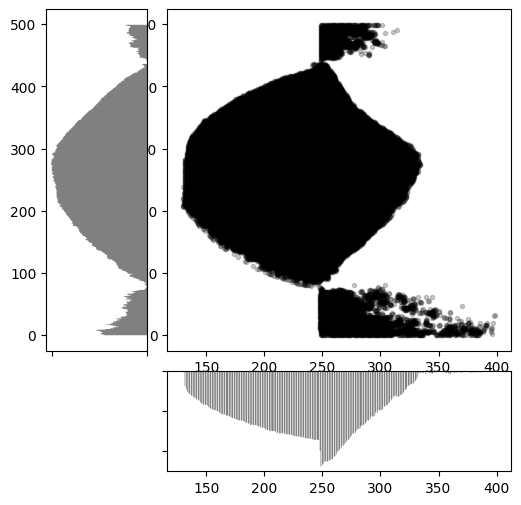

In [102]:

x, y = np.where(binary)

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# histogram on the attached axes
x_hist.hist(x, binary.shape[0], histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, binary.shape[1], histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()